# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import sys
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
#import time (unused in my analysis)
from datetime import datetime
from scipy.stats import linregress

# Import API key
sys.path.insert(0,r'c:\Users\Owen\Desktop\DSV\_HW_Repos\python-api-challenge\common')
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "../output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []
haveEnoughCities = False

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = list(zip(lats, lngs))

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
  
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

632

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
cityObjs = []
for i, city in enumerate(cities):
    try:
        #try to reach api with requests.get()
        print(f'processing: {i}. {city}')
        owdResult = requests.get(f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={weather_api_key}&units=imperial')
    except:
        #error in reaching api
        print('Request aborted. Request Denied')
    
    if owdResult.status_code == 200:
        #verify that return object is proper
        print('complete')
        cityObjs.append(owdResult.json())
    else:
        #error in return object type
        print(f'Request aborted. Status Code: {owdResult.status_code}')

processing: 0. rikitea
complete
processing: 1. albany
complete
processing: 2. narsaq
complete
processing: 3. uvira
complete
processing: 4. faanui
complete
processing: 5. upernavik
complete
processing: 6. ondjiva
complete
processing: 7. hambantota
complete
processing: 8. geraldton
complete
processing: 9. saint george
complete
processing: 10. great yarmouth
complete
processing: 11. ostrovnoy
complete
processing: 12. ushuaia
complete
processing: 13. vysokogornyy
complete
processing: 14. hithadhoo
complete
processing: 15. rafaela
complete
processing: 16. mataura
complete
processing: 17. ambon
complete
processing: 18. port hedland
complete
processing: 19. belogorsk
complete
processing: 20. alyangula
complete
processing: 21. waingapu
complete
processing: 22. thaba-tseka
complete
processing: 23. busselton
complete
processing: 24. saldanha
complete
processing: 25. cayenne
complete
processing: 26. norman wells
complete
processing: 27. luderitz
complete
processing: 28. illoqqortoormiut
Request a

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
#Write city weather data to DataFrame
cityDataDict = {}

#write json data to dataframe row by row
for cityObj in cityObjs:
    # get column data per city from json
    cityID = cityObj['id']
    cityName = cityObj['name']
    cityCountryCode = cityObj['sys']['country']
    cityLat = cityObj['coord']['lat']
    cityLng = cityObj['coord']['lon']
    cityMaxTemp = cityObj['main']['temp_max']
    cityHum = cityObj['main']['humidity']
    cityCloud = cityObj['clouds']['all']
    cityWindSpeed = cityObj['wind']['speed']
    cityDate = datetime.fromtimestamp(cityObj['dt'])
    cityDateFormatted = f'{cityDate.month}/{cityDate.day}/{cityDate.year}'
    #write column data to dictionary
    cityDictEntry = {
                    'city_name': cityName,
                    'lat': cityLat, 
                    'lng': cityLng,
                    'max_temp': cityMaxTemp,
                    'hum': cityHum,
                    'cloud': cityCloud,
                    'wind_speed': cityWindSpeed,
                    'country_code': cityCountryCode,
                    'date': cityDateFormatted
                    }
    #write dictionary to Dataframe
    cityDataDict[cityID] = cityDictEntry
#transpose data to show data columns and city rows
city_data = pd.DataFrame(cityDataDict).transpose()

todaysDate = city_data['date'].mode().values[0]

#Write city weather data to csv
city_data.to_csv(output_data_file, index = False)
city_data.head()

,city_name,lat,lng,max_temp,hum,cloud,wind_speed,country_code,date
4030556,Rikitea,-23.1203,-134.969,80.92,81,33,12.12,PF,3/8/2021
5106841,Albany,42.6001,-73.9662,37.99,28,60,2.71,US,3/8/2021
3421719,Narsaq,60.9167,-46.05,28.4,80,90,2.75,GL,3/8/2021
204405,Uvira,-3.4067,29.1458,73.47,64,99,5.14,CD,3/8/2021
4034551,Faanui,-16.4833,-151.75,82.8,73,100,22.41,PF,3/8/2021


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [6]:
#retain only rows where humidity is less than or equal to 100
city_data = city_data[city_data['hum'] <= 100]


In [7]:
#  Get the indices of cities that have humidity over 100%.
humIndices = city_data[city_data['hum'] > 100].index
humIndices

Int64Index([], dtype='int64')

In [8]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = city_data[~city_data['hum'].isin(humIndices)]
clean_city_data

,city_name,lat,lng,max_temp,hum,cloud,wind_speed,country_code,date
4030556,Rikitea,-23.1203,-134.969,80.92,81,33,12.12,PF,3/8/2021
5106841,Albany,42.6001,-73.9662,37.99,28,60,2.71,US,3/8/2021
3421719,Narsaq,60.9167,-46.05,28.4,80,90,2.75,GL,3/8/2021
204405,Uvira,-3.4067,29.1458,73.47,64,99,5.14,CD,3/8/2021
4034551,Faanui,-16.4833,-151.75,82.8,73,100,22.41,PF,3/8/2021
...,...,...,...,...,...,...,...,...,...
1847947,Shingū,33.7333,135.983,46.67,79,49,4.16,JP,3/8/2021
2965402,Clonakilty,51.6231,-8.8706,44.01,93,75,12.66,IE,3/8/2021
1800764,Mengcheng,33.2579,116.566,47.25,96,100,6.11,CN,3/8/2021
6316343,Alta Floresta,-9.8756,-56.0861,71.58,99,100,4.92,BR,3/8/2021


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

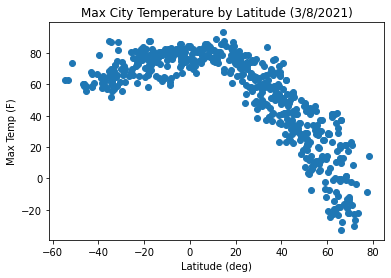

In [9]:
#plot latitude vs. max temp with formatting
plt.scatter(clean_city_data['lat'].values, clean_city_data['max_temp'].values)
plt.title(f'Max City Temperature by Latitude ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Max Temp (F)')
plt.savefig('../output_data/LatTemp')

#Analysis
#The maximum temperature decreases as the latitude of the city moves further from 0 degrees (equator) from near 100F to near 0F

## Latitude vs. Humidity Plot

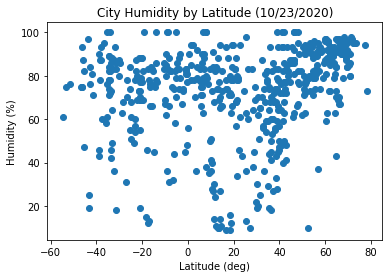

In [11]:
#plot latitude vs. humidity with formatting
plt.scatter(clean_city_data['lat'].values, clean_city_data['hum'].values)
plt.title(f'City Humidity by Latitude ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Humidity (%)')
plt.savefig('../output_data/LatHum')

#Analysis
#The humidity does not show a strong relationship to the latitude of the city for most of the latitude range. Cities with the highest latitude show high humidity values. 

## Latitude vs. Cloudiness Plot

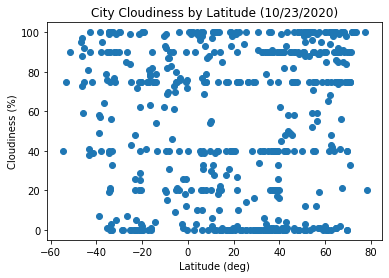

In [12]:
#plot latitude vs. cloudiness with formatting
plt.scatter(clean_city_data['lat'].values, clean_city_data['cloud'].values)
plt.title(f'City Cloudiness by Latitude ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Cloudiness (%)')
plt.savefig('../output_data/LatCloud')

#Analysis
#The cloudiness does not show a significant relationship to the latitude of the city

## Latitude vs. Wind Speed Plot

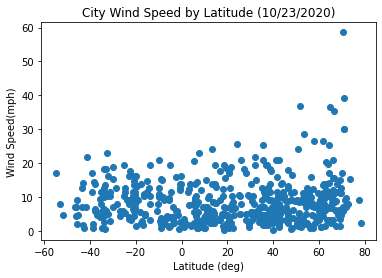

In [13]:
#plot latitude vs. wind speed with formatting
plt.scatter(clean_city_data['lat'].values, clean_city_data['wind_speed'].values)
plt.title(f'City Wind Speed by Latitude ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Wind Speed(mph)')
plt.savefig('../output_data/LatWind')

#Analysis
#The wind speed does not show a significant relationship to the latitude of the city. Most of the wind speeds are recorded below 10 mph but winds speeds near 30 mph have been recorded

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: -0.87


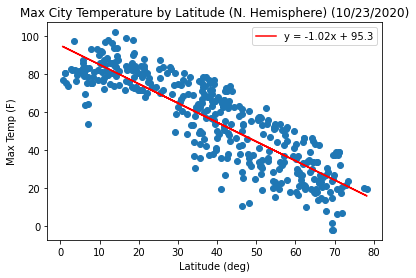

In [14]:
#create city data subset with only northern hempsphere cities
clean_city_data_n = clean_city_data[clean_city_data['lat'] > 0]

#plot latitude vs. max temp with formatting
plt.scatter(clean_city_data_n['lat'].values, clean_city_data_n['max_temp'].values)
plt.title(f'Max City Temperature by Latitude (N. Hemisphere) ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Max Temp (F)')

#get regression data, print r-value
x = clean_city_data_n['lat'].values.tolist()
y = clean_city_data_n['max_temp'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

#create y-vals for regression line, label and plot
yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()
plt.savefig('../output_data/NLatTempRegress')

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.69


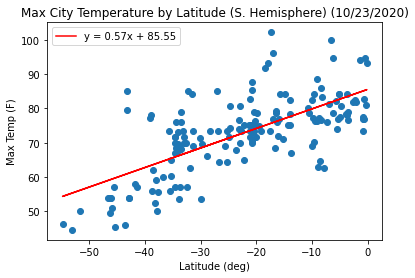

In [15]:
#create city data subset with only southern hempsphere cities
clean_city_data_s = clean_city_data[clean_city_data['lat'] < 0]

#plot latitude vs. max temp with formatting
plt.scatter(clean_city_data_s['lat'].values, clean_city_data_s['max_temp'].values)
plt.title(f'Max City Temperature by Latitude (S. Hemisphere) ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Max Temp (F)')

#get regression data, print r-value
x = clean_city_data_s['lat'].values.tolist()
y = clean_city_data_s['max_temp'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

#create y-vals for regression line, label and plot
yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()
plt.savefig('../output_data/SLatTempRegress')

In [16]:
#Analysis
#In the northern hemisphere, the maximum temperature decreases as the latitude of the city increases
#In the southern hemisphere, the maximum temperature increases as the latitude of the city increases
#both hemispheres show a reduction in temperature as the latitude move away from zero
#the absolute value of r-values of each trend is greater than 0.8, showing a strong correlation relative to other data sets (humidity, wind-speed, cloudiness)
#this is expected because cities near the equator generally record warmer temperatures

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.37


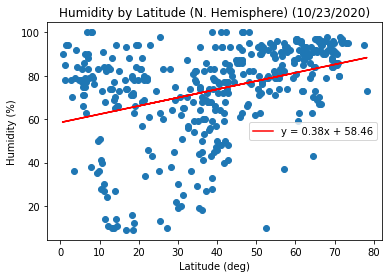

In [17]:
#create city data subset with only northern hempsphere cities
clean_city_data_n = clean_city_data[clean_city_data['lat'] > 0]

#plot latitude vs. humidity with formatting
plt.scatter(clean_city_data_n['lat'].values, clean_city_data_n['hum'].values)
plt.title(f'Humidity by Latitude (N. Hemisphere) ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Humidity (%)')

#get regression data, print r-value
x = clean_city_data_n['lat'].values.tolist()
y = clean_city_data_n['hum'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

#create y-vals for regression line, label and plot
yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()
plt.savefig('../output_data/NLatHumRegress')

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.01


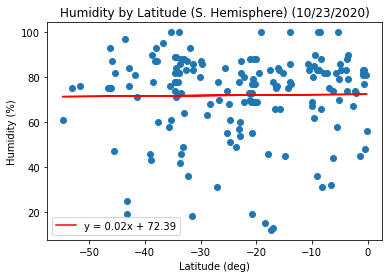

In [18]:
#create city data subset with only southern hempsphere cities
clean_city_data_s = clean_city_data[clean_city_data['lat'] < 0]

#plot latitude vs. humidity with formatting
plt.scatter(clean_city_data_s['lat'].values, clean_city_data_s['hum'].values)
plt.title(f'Humidity by Latitude (S. Hemisphere) ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Humidity (%)')

#get regression data, print r-value
x = clean_city_data_s['lat'].values.tolist()
y = clean_city_data_s['hum'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

#create y-vals for regression line, label and plot
yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()
plt.savefig('../output_data/SLatHumRegress')

In [19]:
#Analysis
#In the northern hemisphere, the humidity increases as the latitude of the city increases. The r-value is low so the correlation is not strong.
#In the southern hemisphere, the humidity and latitude of the city show no visible relationship. The r-value is low so the correlation is not strong.
#this is expected because city latitudes are not known to strongly affect humidities

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.2


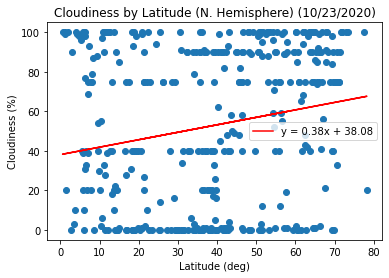

In [20]:
#create city data subset with only northern hempsphere cities
clean_city_data_n = clean_city_data[clean_city_data['lat'] > 0]

#plot latitude vs. cloudiness with formatting
plt.scatter(clean_city_data_n['lat'].values, clean_city_data_n['cloud'].values)
plt.title(f'Cloudiness by Latitude (N. Hemisphere) ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Cloudiness (%)')

#get regression data, print r-value
x = clean_city_data_n['lat'].values.tolist()
y = clean_city_data_n['cloud'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

#create y-vals for regression line, label and plot
yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()
plt.savefig('../output_data/NLatCloudRegress')

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: -0.14


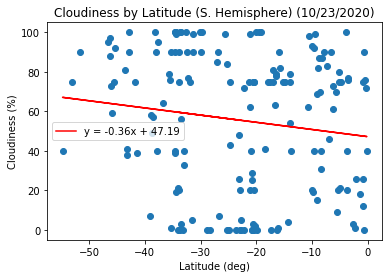

In [21]:
#create city data subset with only southern hempsphere cities
clean_city_data_s = clean_city_data[clean_city_data['lat'] < 0]

#plot latitude vs. cloudiness with formatting
plt.scatter(clean_city_data_s['lat'].values, clean_city_data_s['cloud'].values)
plt.title(f'Cloudiness by Latitude (S. Hemisphere) ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Cloudiness (%)')

#get regression data, print r-value
x = clean_city_data_s['lat'].values.tolist()
y = clean_city_data_s['cloud'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

#create y-vals for regression line, label and plot
yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()
plt.savefig('../output_data/SLatCloudRegress')

In [22]:
#Analysis
#In the northern hemisphere, the cloudiness increases as the latitude of the city increases. The r-value is low so the correlation is not strong.
#In the southern hemisphere, the cloudiness increases as the latitude of the city increases. The r-value is low so the correlation is not strong.
#this is expected because city latitudes are not known to strongly affect cloudiness

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.2


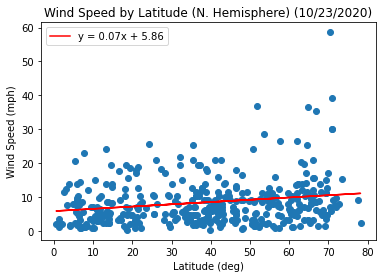

In [23]:
#create city data subset with only northern hempsphere cities
clean_city_data_n = clean_city_data[clean_city_data['lat'] > 0]

#plot latitude vs. wind speed with formatting
plt.scatter(clean_city_data_n['lat'].values, clean_city_data_n['wind_speed'].values)
plt.title(f'Wind Speed by Latitude (N. Hemisphere) ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Wind Speed (mph)')

#get regression data, print r-value
x = clean_city_data_n['lat'].values.tolist()
y = clean_city_data_n['wind_speed'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

#create y-vals for regression line, label and plot
yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()
plt.savefig('../output_data/NLatWindRegress')

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.04


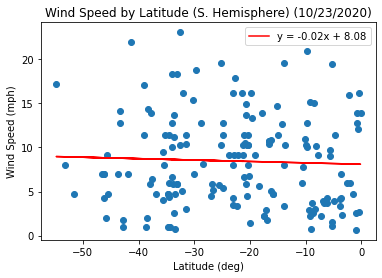

In [24]:
#create city data subset with only southern hempsphere cities
clean_city_data_s = clean_city_data[clean_city_data['lat'] < 0]

#plot latitude vs. wind speed with formatting
plt.scatter(clean_city_data_s['lat'].values, clean_city_data_s['wind_speed'].values)
plt.title(f'Wind Speed by Latitude (S. Hemisphere) ({todaysDate})')
plt.xlabel('Latitude (deg)')
plt.ylabel('Wind Speed (mph)')

#get regression data, print r-value
x = clean_city_data_s['lat'].values.tolist()
y = clean_city_data_s['wind_speed'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

#create y-vals for regression line, label and plot
yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()
plt.savefig('../output_data/SLatWindRegress')

In [25]:
#Analysis
#In the northern hemisphere, the wind speed and latitude of the city show no visible relationship. The r-value is low so the correlation is not strong.
#In the southern hemisphere, the wind speed and latitude of the city show no visible relationship. The r-value is low so the correlation is not strong.
#this is expected because city latitudes are not known to strongly affect wind speed